## Putting what we have together
The broad steps are now quite simple in principle:

1. Set up the model/pipeline

New skill today: dealing with multiple data types in the pipeline using ColumnTransformer

2. Optimize the model's/pipeline's parameters

E.g. What is the "best" strategy for imputing? How should we scale the variables? How many neighbors is the "best"?
Options: GridSearchCV, RandomizedSearchCV, and SK has some model specific -CV functions (e.g. LassoCV)
Tip: print the pipeline to figure out how to specify the parameters keys for GridSearchCV

3. Try new combinations of X variables (which to include), X variable transformations (log, non-linear polynomials), and model types (e.g. regression vs logistic), and optimize each

    1. If you have 40 variables, there are $2^40&gt;billion$ possible combinations. You can't check all of those!
    2. Forward selection:
        a. Start with empty model and add the variable that generates largest score increase (CV score, AIC, BIC, adj R2)
        b. Continue adding variables until some stopping condition is reached
4. Backword selection is the opposite. Start with all variables and remove the least helpful. Continue until some stopping condition is reached. Function: RFECV.

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import metrics


#DL data
url = 'https://github.com/LeDataSciFi/lectures-spr2020/blob/master/assignment_data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip')  

#seperate out y var

y=fannie_mae['Original_Interest_Rate']
fannie_mae.drop('Original_Interest_Rate', axis=1, inplace=True)
fannie_mae.describe()

,Loan_Identifier,Original_UPB,Original_Loan_Term,Original_LTV_(OLTV),Original_Combined_LTV_(CLTV),Number_of_Borrowers,Original_Debt_to_Income_Ratio,Borrower_Credit_Score_at_Origination,Number_of_units,Zip_code_short,...,CPIAUCSL,rGDP,TCMR,POILWTIUSDM,TTLCONS,DEXUSEU,BOPGSTB,GOLDAMGBD228NLBM,CSUSHPISA,MSPUS
count,1.350380e+05,1.350380e+05,135038.000000,135038.000000,134007.000000,135007.00000,132396.000000,134481.000000,135038.000000,135038.000000,...,135038.000000,135038.000000,135038.000000,135038.000000,1.350380e+05,135038.000000,135038.000000,135038.000000,135038.000000,135038.000000
mean,5.518023e+11,1.889311e+05,307.064826,70.057295,70.860858,1.58791,33.298733,742.428797,1.035027,545.976096,...,208.188326,2.083868,3.478040,56.277796,9.631193e+05,1.180771,-42336.575453,845.949803,148.634283,231137.664954
std,2.597821e+11,1.087424e+05,82.331674,17.493178,17.566607,0.50841,11.508698,53.428076,0.244345,306.010624,...,24.776994,2.310579,1.207100,27.841047,1.538464e+05,0.172754,9404.518716,498.115360,24.712708,46186.084143
min,1.000020e+11,8.000000e+03,60.000000,4.000000,4.000000,1.00000,1.000000,361.000000,1.000000,0.000000,...,164.700000,-8.400000,1.504000,11.990000,7.088180e+05,0.852538,-67823.000000,256.197727,93.236000,157400.000000
25%,3.270665e+11,1.080000e+05,240.000000,60.000000,61.000000,1.00000,25.000000,707.000000,1.000000,295.000000,...,183.100000,0.900000,2.324545,30.710000,8.467770e+05,1.072658,-45943.000000,350.765217,130.151000,190100.000000
50%,5.525325e+11,1.640000e+05,360.000000,75.000000,75.000000,2.00000,33.000000,755.000000,1.000000,549.000000,...,212.495000,2.200000,3.675000,48.748636,8.912640e+05,1.191335,-41360.000000,857.726190,145.632000,224100.000000
75%,7.773282e+11,2.470000e+05,360.000000,80.000000,80.000000,2.00000,42.000000,786.000000,1.000000,844.000000,...,231.797000,3.500000,4.347619,81.899524,1.101187e+06,1.316019,-36519.000000,1273.579545,169.868000,258400.000000
max,9.999850e+11,1.170000e+06,360.000000,97.000000,142.000000,8.00000,64.000000,850.000000,4.000000,999.000000,...,251.176000,7.500000,6.661000,133.927143,1.335425e+06,1.575864,-15946.000000,1780.647727,202.411000,337900.000000


## Set up how each data type will get dealt with
Let's start with the continuous numeric variables. Here, I just try a few variables.

In [2]:
num_features=['Original_UPB','Original_Loan_Term', 'Original_Debt_to_Income_Ratio']
num_transformer=Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                               ('scaler', StandardScaler())])

In [3]:
num_transformer
num_transformer.fit(fannie_mae[num_features])
num_transformer.transform(fannie_mae[num_features])

array([[-1.4431508 ,  0.64295267, -0.99098751],
       [ 0.10179076,  0.64295267, -0.63997455],
       [-0.61550354, -1.5433343 , -0.20120835],
       ...,
       [ 0.46043791,  0.64295267, -1.16649399],
       [-0.88218988,  0.64295267, -1.25424723],
       [-0.44997408,  0.64295267,  0.23755786]])

Now the categorical features. Again, just a few variables.

In [4]:
cat_features = ['Property_type', 'Loan_purpose']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

## Combine the column-specific transformations with ColumnTransformer

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [6]:
#preprocessor 

In [7]:
preprocessor.fit(fannie_mae)
pd.DataFrame(preprocessor.transform(fannie_mae))

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.443151,0.642953,-0.990988,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.101791,0.642953,-0.639975,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.615504,-1.543334,-0.201208,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-1.121288,-1.543334,-1.429754,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-1.277621,-1.543334,-2.044026,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,-0.266052,0.642953,-0.464468,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,-0.118915,-1.543334,-0.990988,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,0.966222,0.642953,-0.464468,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,-0.560327,0.642953,0.676324,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9,-0.679876,0.642953,-1.166494,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## This is ready to include in a pipeline with an estimator
It's as easy as: make_pipeline(preprocessor, model_of_your_choice()).

For example:

In [8]:
# combine preprocessor with estimator
pipe_reg = make_pipeline(preprocessor,
                        LinearRegression())
pipe_reg # look at it

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [9]:
pipe_reg.fit(fannie_mae,y)
pipe_reg.predict(fannie_mae) # look at it

array([6.04611923, 5.44110133, 5.07143831, ..., 5.20022512, 5.91738257,
       5.77100248])

### That concludes step 2 in the pseudo, the real-world pipeline is ready!

.

.

.

.

.

.

.

## Optimizing the overly simply model above
Three reasons for doing this:

1. specifying param_grid is just a little different because the pipeline has steps with nested steps
2. one more example of optimizing a model
3. you'll see how I'll evaluate your final model

Optimizing this pipeline is just like the pseudo code above: set up the parameter grid, then the grid to search, then fit and save the optimized model to an object.

In [10]:
# copy and paste this, don't go over - they can figure out later
# get numerical col names (line 1) + post-transform categorical names (line 2)
cols  = preprocessor.transformers_[0][2] .copy()   #t_[0] is num trans,[2] item is col names, copy() so we don't change the underlying data structure!
cols += preprocessor.transformers_[1][1]['onehot']\
                     .get_feature_names(cat_features).tolist()  #t_[1] is cat trans,[1] is steps inside cat trans, get onehot, then pull the feature names

pd.DataFrame(preprocessor.transform(fannie_mae), columns=cols)

,Original_UPB,Original_Loan_Term,Original_Debt_to_Income_Ratio,Property_type_CO,Property_type_CP,Property_type_MH,Property_type_PU,Property_type_SF,Loan_purpose_C,Loan_purpose_P,Loan_purpose_R,Loan_purpose_U
0,-1.443151,0.642953,-0.990988,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.101791,0.642953,-0.639975,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.615504,-1.543334,-0.201208,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-1.121288,-1.543334,-1.429754,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-1.277621,-1.543334,-2.044026,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,-0.266052,0.642953,-0.464468,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,-0.118915,-1.543334,-0.990988,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,0.966222,0.642953,-0.464468,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,-0.560327,0.642953,0.676324,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
9,-0.679876,0.642953,-1.166494,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [11]:
param_grid = {
             'columntransformer__num__imputer__strategy': ['mean', 'median','most_frequent']
             }

_Note how we accessed the column transformer, 2 underscores, then the num transformer inside it, 2 underscores, then the imputer step, then the strategy parameter. I wouldn't have known to do this without looking at the pipe_reg output above._

In [12]:
grid_search = GridSearchCV(pipe_reg, param_grid, cv=5,scoring='r2')
grid_search.fit(fannie_mae, y)
# grid_search.best_params_                   # examined this
opt_model_reg = grid_search.best_estimator_  # save best model to an actual model object

START ASIDE: you can quickly check the model object's R2 in-sample (all of your data) and on the CV folds

In [13]:
# how does this do insample?
print("In sample:          ",metrics.r2_score(y,
                                              opt_model_reg.predict(fannie_mae)
                                             ).round(3)) 

In sample:           0.204


In [14]:
# lol this model generates negative R2 in the CV folds
print("Validation fold avg:",cross_validate(opt_model_reg,
                                            fannie_mae, y,
                                            scoring=['neg_mean_squared_error','r2']
                                           )
                                           ['test_r2'].mean().round(3))


Validation fold avg: -2.824


Lol. You probably will want to include more variables.

END ASIDE

In [15]:
import pickle
filename='finalized_model.sav'
pickle.dump(opt_model_reg, open(filename, 'wb'))

# Exercise 1: Add 5 new continuous varibales to your pipeliine and see how the R2 changes

In [16]:
dumb_nums=fannie_mae.select_dtypes('number').columns.to_list()

#some aren't numbers and some are pointless
ignore=['Loan_Identifier']
dumb_nums=[ele for ele in dumb_nums if ele not in ignore]
dumb_nums

['Original_UPB',
 'Original_Loan_Term',
 'Original_LTV_(OLTV)',
 'Original_Combined_LTV_(CLTV)',
 'Number_of_Borrowers',
 'Original_Debt_to_Income_Ratio',
 'Borrower_Credit_Score_at_Origination',
 'Number_of_units',
 'Zip_code_short',
 'Primary_mortgage_insurance_percent',
 'Co-borrower_credit_score_at_origination',
 'Mortgage_Insurance_type',
 'UNRATE',
 'CPIAUCSL',
 'rGDP',
 'TCMR',
 'POILWTIUSDM',
 'TTLCONS',
 'DEXUSEU',
 'BOPGSTB',
 'GOLDAMGBD228NLBM',
 'CSUSHPISA',
 'MSPUS']

In [17]:
#add new features to the list
num_features=['Original_UPB','Original_Loan_Term','Original_Debt_to_Income_Ratio','UNRATE',
             'rGDP','Original_LTV_(OLTV)','TCMR','CPIAUCSL']

#reload the preprocessor (num_features is new now)
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                               ('cat', cat_transformer, cat_features)]

)

#reload the pipeline

pipe_reg=make_pipeline(preprocessor, LinearRegression())

#check  OOS with CVS
cross_validate(pipe_reg, fannie_mae, y, scoring='r2')['test_score'].mean()

0.6636340659782736

# Exercise 2: Add 2 new categorical varibales (on top of the 5 new continuous vars) and see how R2 changes

In [18]:
fannie_mae.columns

Index(['Loan_Identifier', 'Origination_Channel', 'Seller_Name', 'Original_UPB',
       'Original_Loan_Term', 'Original_LTV_(OLTV)',
       'Original_Combined_LTV_(CLTV)', 'Number_of_Borrowers',
       'Original_Debt_to_Income_Ratio', 'Borrower_Credit_Score_at_Origination',
       'Loan_purpose', 'Property_type', 'Number_of_units', 'Occupancy_type',
       'Property_state', 'Zip_code_short',
       'Primary_mortgage_insurance_percent', 'Product_type',
       'Co-borrower_credit_score_at_origination', 'Mortgage_Insurance_type',
       'Origination_Date', 'First_payment_date',
       'First_time_home_buyer_indicator', 'UNRATE', 'CPIAUCSL', 'Qdate',
       'rGDP', 'TCMR', 'POILWTIUSDM', 'TTLCONS', 'DEXUSEU', 'BOPGSTB',
       'GOLDAMGBD228NLBM', 'CSUSHPISA', 'MSPUS'],
      dtype='object')

In [19]:
cat_deatures=['Property_type', 'Loan_purpose','Product_type','First_time_home_buyer_indicator',
              'Property_state', 'Origination_Channel' ]

#reload the preprocessor (num_features is new now)
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features), 
                                               ('cat', cat_transformer, cat_features)]

)

#reload the pipeline

pipe_reg=make_pipeline(preprocessor, LinearRegression())

#check  OOS with CVS
cross_validate(pipe_reg, fannie_mae, y, scoring='r2')['test_score'].mean()

0.6636340659782736

In [20]:
fannie_mae.columns

Index(['Loan_Identifier', 'Origination_Channel', 'Seller_Name', 'Original_UPB',
       'Original_Loan_Term', 'Original_LTV_(OLTV)',
       'Original_Combined_LTV_(CLTV)', 'Number_of_Borrowers',
       'Original_Debt_to_Income_Ratio', 'Borrower_Credit_Score_at_Origination',
       'Loan_purpose', 'Property_type', 'Number_of_units', 'Occupancy_type',
       'Property_state', 'Zip_code_short',
       'Primary_mortgage_insurance_percent', 'Product_type',
       'Co-borrower_credit_score_at_origination', 'Mortgage_Insurance_type',
       'Origination_Date', 'First_payment_date',
       'First_time_home_buyer_indicator', 'UNRATE', 'CPIAUCSL', 'Qdate',
       'rGDP', 'TCMR', 'POILWTIUSDM', 'TTLCONS', 'DEXUSEU', 'BOPGSTB',
       'GOLDAMGBD228NLBM', 'CSUSHPISA', 'MSPUS'],
      dtype='object')

# Example 3 
add as many variables as possible, say, at least 20 in total- try to select which variables to include in a model.
Groups can try to implement any of the feature selection at the top of the code

In [22]:
ignore=['Loan_Identifier','Origination_Date', 'Qdate']

dumb_nums=fannie_mae.select_dtypes('number').columns.to_list()

dumb_cats=[ele for ele in fannie_mae.columns if ele not in dumb_nums]

#remove
dumb_nums=[ele for ele in dumb_nums if ele not in ignore]
dumb_cats=[ele for ele in dumb_cats if ele not in ignore]

#all others
cat_features=dumb_cats
num_features=dumb_nums


#reload the preprocessor (num_features is new now)
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features), 
    ('cat', cat_transformer, cat_features)])

                                 
#reload the pipeline

pipe_reg = make_pipeline(preprocessor, LinearRegression())

#check  OOS with CVS
cross_validate(pipe_reg, fannie_mae, y, scoring='r2')['test_score'].mean()
                                 

-3.2389751388229044e+16

Now, you can drop in the code from the assignment instructions to save this model to a file I'll evaluate. Make sure to ONLY save your best model!



# Feature Selection - Exercise / Breakout time!
Let's break off into groups and try to select which variables to include in a model.

Groups can try to implement any of the feature selection at the top of the code.

1.Lasso

2.RFECV

3.Boosting

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [24]:
X.shape

(506, 13)

In [25]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [26]:
clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


MSE: 6.6507


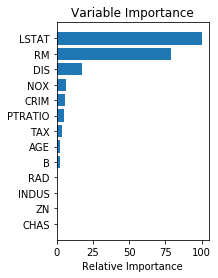

In [28]:
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()